In [235]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels as stats
import matplotlib.pyplot as plt
import datetime

## Exercise 1: Data Preparation and Visualization

Task: Choose a stock (e.g., Apple: 'AAPL', Google: 'GOOGL') from the yfinance module. Download the last 5 years of daily data.

Goals:

* Extract the closing price and plot it.

* Check for any missing values and handle them appropriately.

* Perform a brief analysis of the time series plot.

Feedback: Submit your plot and your observations about the trend, seasonality, and any anomalies you notice.

In [236]:
# Download last 5 years of Closing price data and store it inside a dataframe
end = datetime.datetime.now()
timedelta = datetime.timedelta(days=365 * 5)
start = end - timedelta
df_aapl = yf.download("AAPL", start, end)["Adj Close"]  # only get the Adj Close column
print("Number of missing values =", df_aapl.isnull().sum())  # no missing values
print(df_aapl)

[*********************100%%**********************]  1 of 1 completed
Number of missing values = 0
Date
2018-12-10     40.695980
2018-12-11     40.463230
2018-12-12     40.575996
2018-12-13     41.019917
2018-12-14     39.707382
                 ...    
2023-12-01    191.240005
2023-12-04    189.429993
2023-12-05    193.419998
2023-12-06    192.320007
2023-12-07    194.270004
Name: Adj Close, Length: 1258, dtype: float64


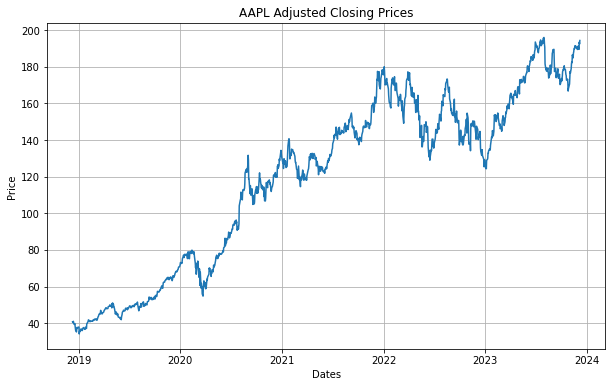

In [237]:
# Plot the closing prices
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_aapl)
ax.set(title="AAPL Adjusted Closing Prices", xlabel="Dates", ylabel="Price")
ax.grid()

Brief Analysis:

* AAPL generally has an upward trend with no visible seasonality.
* After 5 years, it had nearly %400 rate of returns.

## Exercise 2: Stationarity and Differencing

Task: Test the stationarity of your chosen time series.

Goals:

* Perform an Augmented Dickey-Fuller test.

* Based on the test, decide whether to difference the data. If yes, determine the order of differencing.

Feedback: Share your ADF test results and your rationale for the differencing decision.

In [238]:
# Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
adfuller_test = adfuller(df_aapl)

# Print the results
print('ADF Statistic: %f' % adfuller_test[0])
print('p-value: %f' % adfuller_test[1])

ADF Statistic: -0.954875
p-value: 0.769365


Because the $p$ value is $p > 0.05$, we fail to reject the null hypothesis and decide that our Augmented Dickey-Fuller Test shows us this time series has a unit root and is **non-stationary**.

Then, we must find a proper $d$ value for $\nabla^d X_t$ which is the level of **differencing** we shall use in our $ARIMA(p, d, q)$ model.

In [239]:
# Create a differencing dataframe
diffdict = {}
diffdict[1] = df_aapl.diff().dropna()
diffdict[2] = diffdict[1].diff().dropna()
diffdict[3] = diffdict[2].diff().dropna()
diff_df = pd.DataFrame(diffdict, df_aapl.index)
diff_df = diff_df.dropna()
diff_df

,1,2,3
Date,,,
2018-12-13,0.443920,0.331154,-0.014362
2018-12-14,-1.312534,-1.756454,-2.087608
2018-12-17,-0.369530,0.943005,2.699459
2018-12-18,0.511097,0.880627,-0.062378
2018-12-19,-1.242958,-1.754055,-2.634682
...,...,...,...
2023-12-01,1.290009,0.710007,-0.899994
2023-12-04,-1.810013,-3.100021,-3.810028
2023-12-05,3.990005,5.800018,8.900040


In [240]:
adfuller(diff_df.loc[:, 1])

(-36.87978749907668,
 0.0,
 0,
 1254,
 {'1%': -3.4355754676859886,
  '5%': -2.8638475772391665,
  '10%': -2.5679985805677017},
 5629.941275976151)

In [241]:
# Apply Augmented Dickey-Fuller test for all differencing (d) values
adf_pvalues = {}
for col in diff_df.columns:
    adf_pvalues[col] = adfuller(diff_df.loc[:, col])[1]  # 1st index is the p value
print(adf_pvalues)

{1: 0.0, 2: 2.5391646403511088e-24, 3: 2.3279014690272596e-29}


It looks like first differencing gives us a stationary time series. Let's plot just to be sure:

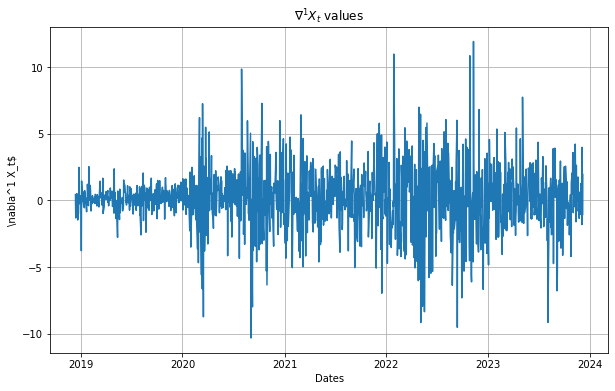

In [242]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(diff_df.loc[:, 1])
ax.set(title=r"$\nabla^1 X_t$ values", xlabel="Dates", ylabel=r"\nabla^1 X_t$")
ax.grid()

By looking at the plot we can also say from 2020 onwards, variance of the first differences seem to be constant and we can say the $\nabla^1 X_t$ values of this time series is **stationary**. Then for the $ARIMA(p, d, q)$ model we can choose $d=1$.

## Exercise 3: ARIMA Model Specification
Task: Choose an ARIMA model for your data.

Goals:

* Determine the ARIMA(p,d,q) order. You can use ACF and PACF plots for guidance.

* Fit the ARIMA model with the chosen order.

Feedback: Discuss why you chose the specific (p,d,q) values and present the summary of your model fit.

In [243]:
"""
We have decided our d value should be 1. Now, let's add to our main dataframe the differencing values and drop NaN values.
"""
df_aapl = pd.DataFrame(df_aapl)
df_aapl["d=1"] = df_aapl.diff()
df_aapl = df_aapl.dropna()
df_aapl

,Adj Close,d=1
Date,,
2018-12-11,40.463230,-0.232750
2018-12-12,40.575996,0.112766
2018-12-13,41.019917,0.443920
2018-12-14,39.707382,-1.312534
2018-12-17,39.337852,-0.369530
...,...,...
2023-12-01,191.240005,1.290009
2023-12-04,189.429993,-1.810013
2023-12-05,193.419998,3.990005


We first try to fit an $AR(p)$ process to the first order difference of $X_t$ that is $\nabla X_t$ with linear coefficients which is the same as an OLS regression where predictors are lagged values of $X_t$ which is the definition of an $AR$ model. After that, we are going to look at the ACF and PACF of residuals from OLS to decide on an $MA(q)$ process and $q$ value:

$\nabla X_t = \alpha_1 \nabla X_{t-1} + \alpha_2 \nabla X_{t-2} + \cdots + \alpha_p \nabla X_{t-p} + \varepsilon_t$

where $\varepsilon_t$ ~ $N(0, \sigma^2)$

In [244]:
# Import modules
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# fit an AR(20) model to first order difference of X_t, where 20 is arbitrarily chosen.
aapl_ar20 = ARIMA(df_aapl["d=1"], order=(20, 0, 0), trend="n").fit()
print(aapl_ar20.summary())

/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    d=1   No. Observations:                 1257
Model:                ARIMA(20, 0, 0)   Log Likelihood               -2850.256
Date:                Fri, 08 Dec 2023   AIC                           5742.511
Time:                        12:43:38   BIC                           5850.378
Sample:                             0   HQIC                          5783.051
                               - 1257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0276      0.024     -1.160      0.246      -0.074       0.019
ar.L2         -0.0286      0.023     -1.251      0.211      -0.073       0.016
ar.L3         -0.0050      0.025     -0.197      0.8

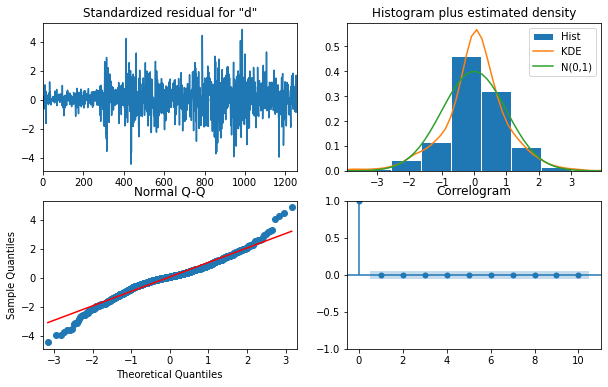

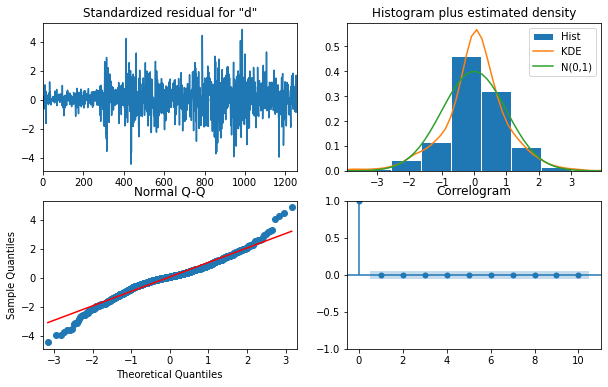

In [245]:
# Now we plot residual diagnostics to look at ACF and PACf values to decide on an MA(q) process.
aapl_ar20.plot_diagnostics(figsize=(10, 6))

Because the correlogram shows no correlation between residuals, we can safely choose $q=0$ and the MA model as $MA(0)$

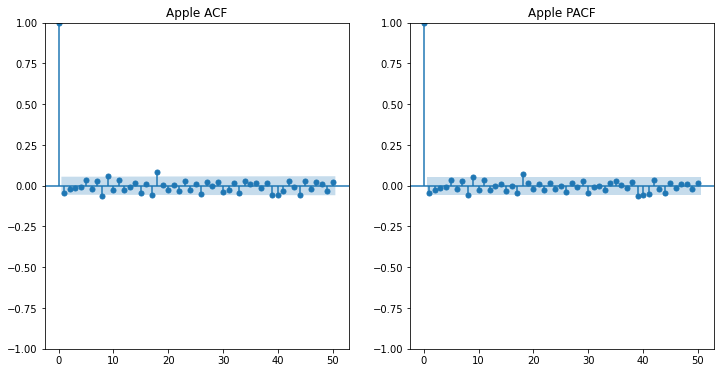

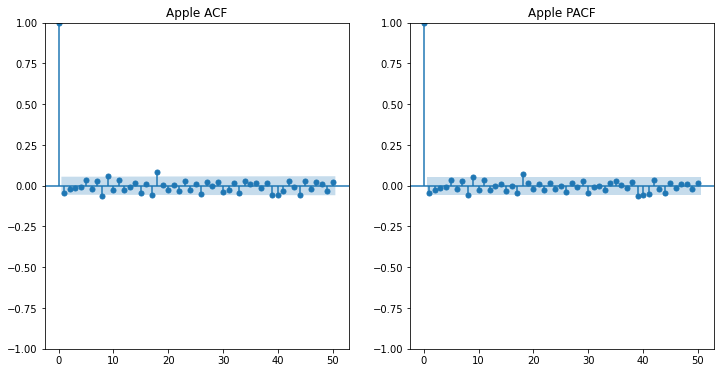

In [246]:
# Import modules
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Visually check ACF and PACF to make a guess about p, q values
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sm.graphics.tsa.plot_acf(df_aapl["d=1"], title="Apple ACF", lags=50, ax=axs[0])
sm.graphics.tsa.plot_pacf(df_aapl["d=1"], title="Apple PACF", lags=50, ax=axs[1])

It looks like in the first order difference time series of **AAPL**, there seems to be no autocorrelation or partial autocorrelation to any past values. There is just statistically significant correlation at near 18 lag but it should most likely be a statistical anomaly. Then we can choose $p=0, q=0$ and decide for an $ARIMA(0, 1, 0)$ model where our AAPL returns are an iid white noise time series {$\varepsilon_t$} s.t. $\varepsilon_i$ ~ $N(0, \sigma^2)$ for any $i=1, 2, \cdot$

However, let's use an automated ARIMA selector to check if we are right:

In [247]:
from pmdarima.arima import auto_arima
# Efficient ARIMA model Selection
mod_can_auto = auto_arima(
    df_aapl["Adj Close"],  # stepwise=False,
    start_p=0,
    start_d=0,
    start_q=0,
    max_p=3,
    max_d=3,
    max_q=3,
    trace=True,
    with_intercept=False,
    return_valid_fits=True,
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5728.532, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5728.636, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5728.551, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5729.974, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5727.160, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5726.985, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5728.219, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5728.048, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5726.873, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5728.128, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5729.978, Time=0.46 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.327 seconds


Looking at the results, it seems like all of the possible values have close AIC values so our intuition about an ARIMA(0, 1, 0) model can be considered correct:

* **AAPL** <u> returns </u> are <u> white noise </u> and can be modeled by an $ARIMA(0, 0, 0)$ model.
* **AAPL** <u> stock prices </u> are <u> random walk </u> without a drift, mean = 0, and can be modeled by an $ARIMA(0, 1, 0)$ model.

In [248]:
aapl_arima = ARIMA(df_aapl["Adj Close"], order=(0, 1, 0), trend="n").fit()
aapl_arima.summary()

/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1257
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2863.266
Date:                Fri, 08 Dec 2023   AIC                           5728.532
Time:                        12:43:42   BIC                           5733.668
Sample:                             0   HQIC                          5730.463
                               - 1257                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.5927      0.147     38.154      0.000       5.305       5.880
===================================================================================
Ljung-Box (L1) (Q):                   2.18   Jarque-Bera (JB):               374.32
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               3.40   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

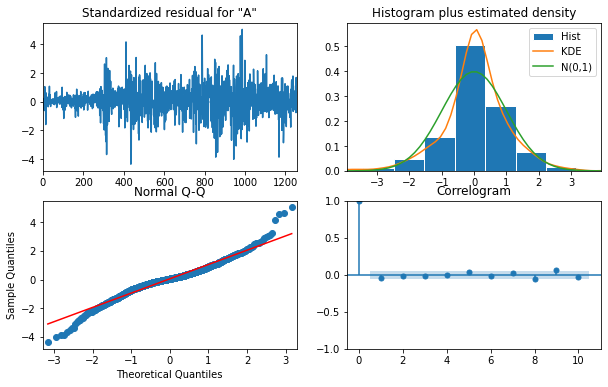

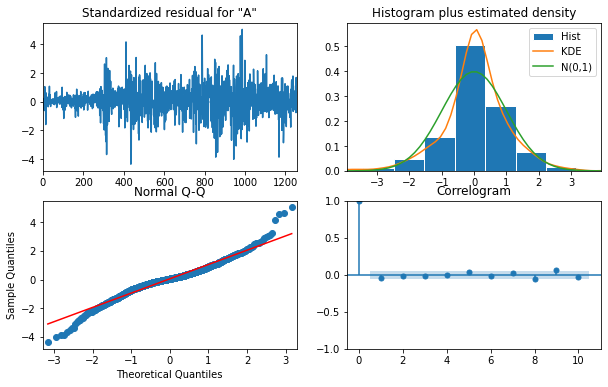

In [249]:
aapl_arima.plot_diagnostics(figsize=(10, 6))

Because residuals show no autocorrelation, we can safely say our choice of $p, q$ values for $ARIMA(p, q, d)$ is as good as any other selection of parameters.